In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#base_dir = 'content/drive/MyDrive/Brian_tumor_classification'
import os
os.chdir('/content/drive/MyDrive/Brain')

#Custom CNN

In [ ]:
!pwd

/content/drive/MyDrive/Brain


In [ ]:
# !mkdir brain_tumor_dataset

In [ ]:
# !ls

In [ ]:
# !unzip brain_tumor_dataset.zip -d brain_tumor_dataset/

In [ ]:
! ls

brain_tumor_dataset	 CCNN	       saved	    VGG16
brain_tumor_dataset.zip  mobilenet_v2  saved_model


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import PIL
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import layers, activations
from keras.layers import Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Flatten, Dropout, BatchNormalization, RandomZoom, RandomFlip, RandomRotation, RandomContrast
from keras.models import Sequential
import datetime
import seaborn as sns
from sklearn.metrics import multilabel_confusion_matrix, classification_report, confusion_matrix

In [ ]:
data_dir = '/content/drive/MyDrive/Brain/brain_tumor_dataset/'
data_dir

'/content/drive/MyDrive/Brain/brain_tumor_dataset/'

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir  

PosixPath('/content/drive/MyDrive/Brain/brain_tumor_dataset')

In [ ]:
image_count = len(list(data_dir.glob('*/*/*.jpg')))
image_count

7023

In [ ]:
glioma_tumor = list(data_dir.glob('*/glioma/*'))
glioma_tumor[:5]

[PosixPath('/content/drive/MyDrive/Brain/brain_tumor_dataset/Testing/glioma/Te-glTr_0002.jpg'),
 PosixPath('/content/drive/MyDrive/Brain/brain_tumor_dataset/Testing/glioma/Te-glTr_0005.jpg'),
 PosixPath('/content/drive/MyDrive/Brain/brain_tumor_dataset/Testing/glioma/Te-glTr_0004.jpg'),
 PosixPath('/content/drive/MyDrive/Brain/brain_tumor_dataset/Testing/glioma/Te-glTr_0003.jpg'),
 PosixPath('/content/drive/MyDrive/Brain/brain_tumor_dataset/Testing/glioma/Te-glTr_0001.jpg')]

In [ ]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

In [ ]:
X = [] #Training Dataset
y = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join(data_dir, 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X.append(image)
        y.append(i)
        
        
for i in labels:
    folderPath = os.path.join(data_dir, 'Testing', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X.append(image)
        y.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X = np.array(X)
y = np.array(y)

100%|██████████| 300/300 [00:05<00:00, 53.00it/s] 


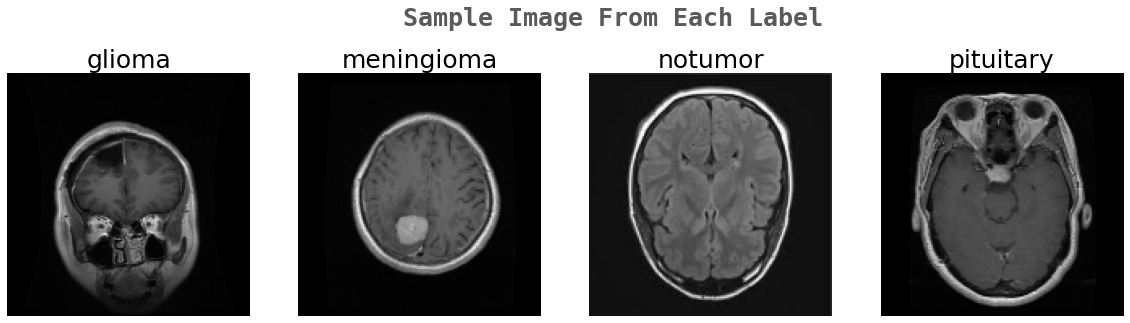

In [ ]:
colors = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']

k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=25,fontweight='bold',
             fontname='monospace',color=colors[1],y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y[j]==i:
            ax[k].imshow(X[j])
            ax[k].set_title(y[j], fontsize=25)
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X.shape

(7023, 150, 150, 3)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=142)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=142)

In [ ]:
X_train.shape

(6320, 150, 150, 3)

In [ ]:
X_test.shape

(703, 150, 150, 3)

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train=y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test=y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
X_train.shape

(6320, 150, 150, 3)

In [ ]:
y_test.shape

(703, 4)

In [ ]:
IMG_SIZE = 150

resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255)
])

In [ ]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal", input_shape=(150, 150, 3)),
    tf.keras.layers.RandomRotation(0.2, fill_mode='reflect'),
    tf.keras.layers.RandomContrast(0.2),
  ]
)

In [ ]:
#original
num_classes = 4

model = Sequential([
    resize_and_rescale,
    data_augmentation,
    Conv2D(64, 3, padding='same', activation= 'relu', input_shape=(150,150,3)),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Conv2D(64, 5, padding='same', activation= 'relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Conv2D(256, 5, padding='same', activation= 'relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Conv2D(512, 5, padding='same', activation= 'relu'),
    MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    BatchNormalization(),
    Flatten(),
    Dropout(0.3),
    Dense(256, activation= 'relu'),
    Dropout(0.3),
    Dense(64, activation= 'relu'),
    Dropout(0.3),
    Dense(num_classes, activation= 'softmax')
])

model.build(input_shape=(None,150,150,3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 74, 74, 64)       

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

history = model.fit(X_train,
                     y_train, 
                     validation_data=(X_test, y_test),
                     epochs=40,
                     batch_size= 32)

Epoch 1/40


198/198 [==============================] - 43s 190ms/step - loss: 1.0195 - accuracy: 0.6225 - val_loss: 5.2347 - val_accuracy: 0.2745
Epoch 2/40
198/198 [==============================] - 34s 171ms/step - loss: 0.7546 - accuracy: 0.7090 - val_loss: 6.1050 - val_accuracy: 0.3300
Epoch 3/40
198/198 [==============================] - 34s 169ms/step - loss: 0.6723 - accuracy: 0.7465 - val_loss: 1.6670 - val_accuracy: 0.6159
Epoch 4/40
198/198 [==============================] - 34s 170ms/step - loss: 0.5476 - accuracy: 0.7911 - val_loss: 0.4124 - val_accuracy: 0.8378
Epoch 5/40
198/198 [==============================] - 35s 177ms/step - loss: 0.5047 - accuracy: 0.8090 - val_loss: 0.4021 - val_accuracy: 0.8748
Epoch 6/40
198/198 [==============================] - 34s 172ms/step - loss: 0.4467 - accuracy: 0.8335 - val_loss: 1.9918 - val_accuracy: 0.6230
Epoch 7/40
198/198 [==============================] - 34s 172ms/step - loss: 0.4187 - accuracy: 0.8421 - val_loss: 0.5718 - val_accuracy: 0.8

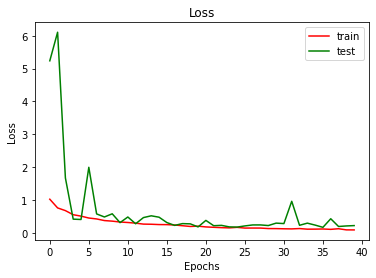

In [ ]:
#model 1
plt.plot(history.history["loss"],c = "red")
plt.plot(history.history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

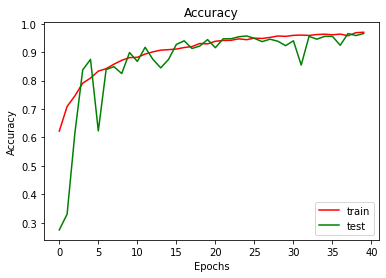

In [ ]:
#model1
plt.plot(history.history["accuracy"],c = "red")
plt.plot(history.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# Getting model predictions model2

test_predictions = model.predict(X_test)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, preds))

22/22 [==============================] - 0s 18ms/step
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       159
           1       0.97      0.91      0.93       158
           2       0.96      0.98      0.97       193
           3       0.97      0.99      0.98       193

    accuracy                           0.97       703
   macro avg       0.97      0.96      0.96       703
weighted avg       0.97      0.97      0.97       703



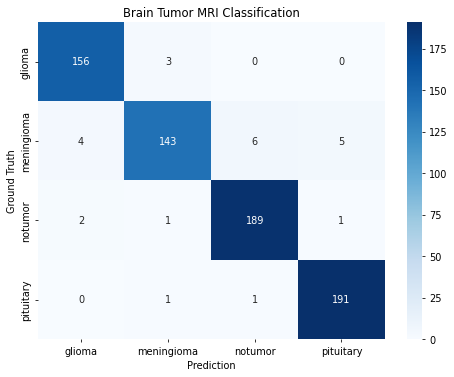

In [ ]:
#model2

cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [ ]:
!mkdir saved

In [ ]:
!pwd

/content/drive/MyDrive/Brain_tumor_classification


In [ ]:
# model = tf.keras.models.load_model('content/drive/MyDrive/Brain/saved_model/CCNN.h5')
os.chdir('/content/drive/MyDrive/Brain/CCNN/')
!ls

In [ ]:
import pickle

f = open('history4.pckl', 'wb')
history4 = pickle.dump(history.history, f)
f.close()

In [ ]:
os.chdir('/content/drive/MyDrive/Brain/saved_model') 

In [ ]:
# from keras.models import save
model.save("CCNN.h5", save_format="h5")

In [ ]:
!mkdir graph

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph')

In [ ]:
!mkdir CNN

In [ ]:
os.chdir('/content/drive/MyDrive/Brain_tumor_classification/graph/CNN')

In [ ]:

import pickle


f = open('history.pckl', 'wb')
history = pickle.dump(history, f)
f.close()

In [ ]:
f = open('history.pckl', 'rb')
history2 = pickle.load(f)
f.close()

In [ ]:
history2.history["val_accuracy"]

[0.3029871881008148,
 0.3029871881008148,
 0.7539117932319641,
 0.874822199344635,
 0.8876244425773621,
 0.8634423613548279,
 0.7482219338417053,
 0.8790895938873291,
 0.9246088266372681,
 0.8847795128822327,
 0.7738264799118042,
 0.7937411069869995,
 0.7368420958518982,
 0.8591749668121338,
 0.8406828045845032,
 0.9146515130996704,
 0.9160739779472351,
 0.7368420958518982,
 0.9274537563323975,
 0.9459459185600281,
 0.8634423613548279,
 0.9487909078598022,
 0.9317212104797363,
 0.9559032917022705,
 0.9601706862449646,
 0.9573257565498352,
 0.904694139957428,
 0.9032716751098633,
 0.9132290482521057,
 0.9445234537124634,
 0.758179247379303,
 0.9118065237998962,
 0.9374110698699951,
 0.9260312914848328,
 0.9758179187774658,
 0.9203413724899292,
 0.9729729890823364,
 0.9431009888648987,
 0.9701279997825623,
 0.9758179187774658]

In [ ]:
# model = tf.keras.models.load_model('content/drive/MyDrive/Brain/saved_model/CCNN.h5')
os.chdir('/content/drive/MyDrive/Brain/saved_model/')
!ls

CCNN  CNN  CNN2  Final_CNN  mobilenet


In [ ]:
from keras.models import load_model
model = load_model('CCNN')

#for model's summary and details.
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 150, 150, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 150, 150, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 50, 50, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 64)       

In [ ]:
os.chdir('/content/drive/MyDrive/Brain/CCNN/')
import pickle

f = open('history.pckl', 'rb')
history = pickle.load(f)
f.close()

In [ ]:
history["val_accuracy"]

[0.26031294465065,
 0.3527738153934479,
 0.6586059927940369,
 0.8093883395195007,
 0.7766714096069336,
 0.8876244425773621,
 0.8890469670295715,
 0.7823613286018372,
 0.829302966594696,
 0.8847795128822327,
 0.9431009888648987,
 0.8335704207420349,
 0.846372663974762,
 0.7837837934494019,
 0.8975818157196045,
 0.9502133727073669,
 0.8634423613548279,
 0.8648648858070374,
 0.8847795128822327,
 0.8904694318771362,
 0.8506401181221008,
 0.9431009888648987,
 0.9743954539299011,
 0.9516358375549316,
 0.7780938744544983,
 0.9658606052398682,
 0.829302966594696,
 0.8790895938873291,
 0.9502133727073669,
 0.9231863617897034,
 0.9615931510925293,
 0.954480767250061,
 0.9601706862449646,
 0.954480767250061,
 0.9644381403923035,
 0.8733997344970703,
 0.9786628484725952,
 0.9445234537124634,
 0.9530583024024963,
 0.9687055349349976]

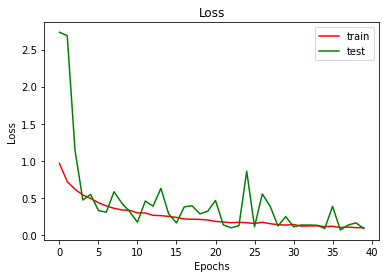

In [ ]:
#model 1
plt.plot(history["loss"],c = "red")
plt.plot(history["val_loss"],c = "green")
plt.title("Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

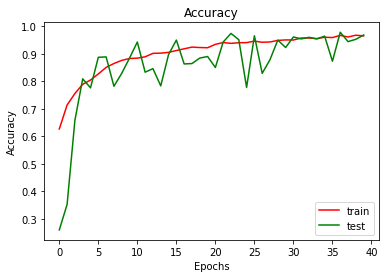

In [ ]:
#model1
plt.plot(history["accuracy"],c = "red")
plt.plot(history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend(["train", "test"])
plt.show()

In [ ]:
# Getting model predictions model2

test_predictions = model.predict(X_test)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(y_test, axis=1)
print(classification_report(actual_label, preds))

22/22 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.97       159
           1       0.98      0.91      0.94       158
           2       0.98      0.99      0.99       193
           3       0.96      0.99      0.98       193

    accuracy                           0.97       703
   macro avg       0.97      0.97      0.97       703
weighted avg       0.97      0.97      0.97       703



In [ ]:
# model2.save('saved_model/CCNN', save_format='h5')